In [ ]:
def anagram(string1, string2):
    a = ''.join(sorted(string1))
    b = ''.join(sorted(string2))
    if a==b:
        return True
    else:
        return False

In [39]:
def reverse_word(string):
    n = len(string)//2
    tail=[]
    for i in range(n):
        tail.append(string[-i-1])
    b = ''.join(tail)
    a = string[:n]
    return a==b

# This is a backtester for corridor dispersion vol swap

In [44]:
import pandas as pd
import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

data = pd.read_csv('C:\\Users\\doraz\\Downloads\\price.csv',index_col = 'Date')
data.index = pd.to_datetime(data.index) # HACK (remove after pandas version >= 0.24)

weights_data =pd.read_csv("C:\\Users\\doraz\\Downloads\\constituents.csv")

In [45]:
def basket_weight(weights_data, startdate, basket_size):
    ## based on the start date, select the top 50 names, and weights
    
    ### TODO: tune your data fetching logic based on your data format
    ### now below assumes column like: Symbol | 2014 | Symbol | 2015 | Symbol | 2016
    year = startdate.year
    col_loc = weights_data.columns.get_loc(str(year))
    df =pd.DataFrame()
    df['tickers']=weights_data.iloc[:,col_loc-1]
    df['weights']=weights_data.iloc[:,col_loc]
    df = df.sort_values(['weights'],ascending = False).head(basket_size)
    df['weights'] = df['weights']/df['weights'].sum()
    df['weights'].iloc[-1] = 1-df['weights'].iloc[0:-1].sum()
    
    return df['tickers'].tolist(), df['weights'].tolist()
    

def next_day(items, pivot):
    #return min(items, key=lambda x: abs(x - pivot))
    return min(item for item in items if item > pivot)
def prev_day(items,pivot):
    return min(item for item in items if item < pivot)

def backtest_date(frequency,maturity,startdate,enddate, price_data):
    start_dts = []
    end_dts = []
    start_date = pd.date_range(pd.to_datetime(startdate),pd.to_datetime(enddate)-timedelta(days=maturity), freq=frequency)
    end_date = pd.date_range(pd.to_datetime(startdate)+timedelta(days=maturity),pd.to_datetime(enddate), freq=frequency)
    for i in range(len(start_date)):
        if start_date[i] in price_data.index:
            start_dts.append(start_date[i])
        else:
            start_dts.append(next_day(price_data.index,start_date[i]))
            
    for i in range(len(end_date)):
        if end_date[i] in price_data.index:
            end_dts.append(end_date[i])
        else:
            end_dts.append(next_day(price_data.index,end_date[i]))
    return start_dts, end_dts
    

In [46]:
def corridor_vol_swap(startdate, enddate, tickers, benchmark, weights, convention,b1, b2, px_data):
    data_select_period= px_data[(px_data.index > pd.to_datetime(startdate)) & 
                         (px_data.index < pd.to_datetime(enddate))]
    basket = data_select_period[tickers]
    bsk_ret = basket/basket.shift()-1 
    index_px= data_select_period[[benchmark]]
    ind_ret = index_px/index_px.shift()-1

    if convention =='T':  # convention is not used in code yet!!
        index_px['bool']=(index_px>(b1*index_px.iloc[0]))&(index_px<(b2*index_px.iloc[0]))  # To Check< or <=, > or >=

    elif convention =='T-1':
        index_px['bool']=(index_px.shift(1)>(b1*index_px.iloc[0]))&(index_px.shift(1)<(b2*index_px.iloc[0]))  # To Check< or <=, > or >=

    elif convention =='BOTH':
        index_px['bool']=(index_px>(b1*index_px.iloc[0]))&(index_px<(b2*index_px.iloc[0]))&\
        (index_px.shift(1)>(b1*index_px.iloc[0]))&(index_px.shift(1)<(b2*index_px.iloc[0]))# To Check< or <=, > or >=
    else:
        index_px['bool']=1
        
    bsk_ret_corr=bsk_ret.iloc[1:].multiply(index_px['bool'].iloc[1:],axis=0)
    ind_ret_corr=ind_ret.iloc[1:].multiply(index_px['bool'].iloc[1:],axis=0)
    vol_corr_bsk=(np.sqrt((bsk_ret_corr**2).sum()*252/index_px['bool'].sum())*weights).sum()
    vol_corr_ind=(np.sqrt((ind_ret_corr**2).sum()*252/index_px['bool'].sum())).sum()
    counts=index_px['bool'].iloc[1:].sum()
    index_total_perf=index_px.iat[-1,0]/index_px.iat[0,0]-1
    
    #return enddate, vol_corr_bsk, vol_corr_ind, vol_corr_bsk-vol_corr_ind,counts,index_px.iat[-1,0],index_total_perf
    return enddate, vol_corr_bsk-vol_corr_ind,counts,index_total_perf
    

    

In [31]:
  
def backetest(startdate, enddate, convention, b1, b2, maturity, basket_size,backtest_frequency, 
                px_data, benchmark='SPY',tickers=None,weights=None, weights_data=None):

    if weights_data.empty and (tickers is None and weights is None):
        raise ValueError('Users need to supply at least one of weights_data or (tickers+weights)')
        
    table=[]
    start_dts,end_dts = backtest_date(backtest_frequency,maturity,startdate,enddate,data)
    for i in range(len(end_dts)):
        if not weights_data.empty:
            tickers,weights = basket_weight(weights_data,startdate, basket_size)
        table.append(corridor_vol_swap(start_dts[i], end_dts[i], tickers, benchmark, weights,convention,b1,b2,px_data))
        
    table = pd.DataFrame(table,columns =['time','realized_VolS','Ndays_in_corridor','index_return'])
    return table


In [47]:
df_70_100 = backetest(datetime.date(2015,1,1), datetime.date(2018,12,31), 'T-1', 0.7, 1.0, 360, 5,'BMS',
                      data,weights_data=weights_data)
df_vanilla =backetest(datetime.date(2015,1,1), datetime.date(2018,12,31), 'vanilla', 0.7, 1.0, 360, 5,'BMS',
                      data,weights_data=weights_data)
df_70_110 =backetest(datetime.date(2015,1,1), datetime.date(2018,12,31), 'T-1', 0.7, 1.1, 360, 5,'BMS',
                      data,weights_data=weights_data)
# backetest(startdate, enddate, convention, b1, b2, maturity, basket_size,backtest_frequency, 
#                 data, benchmark=benchmark,tickers=None, weights=None, weights_data=weights_data)

C:\Users\doraz\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\doraz\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\doraz\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

In [49]:
df_70_100.head()
df_70_110.head()

,time,realized_VolS,Ndays_in_corridor,index_return
0,2016-01-04,0.134881,250,0.010658
1,2016-02-01,0.132554,249,-0.054286
2,2016-03-01,0.137391,250,-0.083175
3,2016-04-01,0.140938,250,-0.004456
4,2016-05-02,0.137910,250,-0.023614


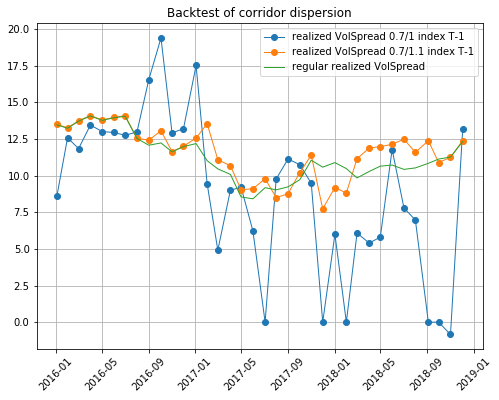

In [51]:
plt.figure(figsize =(8,6))

# years = mdates.YearLocator()   # every year
# months = mdates.MonthLocator()  # every month
# years_fmt = mdates.DateFormatter('%Y-%m')

# ax = plt.subplot(gridspec.GridSpec(4,1)[0,0])
# format the ticks
# years = mdates.YearLocator()   # every year
# months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y-%m')

# ax.xaxis.set_major_locator(months)
# ax.xaxis.set_major_formatter(years_fmt)
# ax.xaxis.set_minor_locator(months)

plt.plot(df_70_100['time'],df_70_100['realized_VolS']*100,
         label='realized VolSpread ' + str(0.7) + '/' + str(1) + ' index ' + convention,
         linewidth=1.0, 
         marker='o')
plt.plot(df_70_110['time'],df_70_110['realized_VolS']*100,
         label='realized VolSpread ' + str(0.7) + '/' + str(1.1) + ' index ' + convention,
         linewidth=1.0, 
         marker='o')
plt.plot(df_vanilla['time'],df_vanilla['realized_VolS']*100,label='regular realized VolSpread ',linewidth=1.0)
plt.title('Backtest of corridor dispersion')
plt.grid()
plt.legend(loc ='best')

plt.xticks(rotation='45')

plt.show()




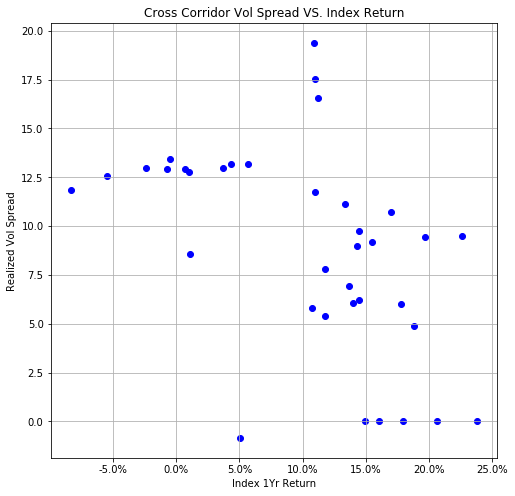

<Figure size 864x2160 with 0 Axes>

In [54]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.set_xlabel('Index 1Yr Return', fontsize=10)
ax.xaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_ylabel('Realized Vol Spread', fontsize=10)

# ax.yaxis.set_major_locator(locator=)

ax.grid(True)
# fig.tight_layout()

plt.scatter(df_70_100['index_return']*100, df_70_100['realized_VolS']*100,alpha=1, 
            marker='o', c='blue',label='realized VolSpread ' + str(0.7) + '/' + str(1) + ' index ' + convention)
plt.title('Cross Corridor Vol Spread VS. Index Return', fontsize=12)
plt.figure(figsize =(12,30))
plt.show()